<a href="https://colab.research.google.com/github/eaderogba/MP_Detection_ML/blob/main/Copy_of_classification_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization,Activation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
# Load data from google drive
drive.mount('/content/drive')
train_dir = "/content/drive/MyDrive/Colab Notebooks/Malaria parasite images/Train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Malaria parasite images/Test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your Train and Test directory
train_dir = r'C:\Users\OMEN\MP_Detect\Train'
test_path = r'C:\Users\OMEN\MP_Detect\Test'

In [ ]:
# Parameters for batch size, image height and width
batch_size = 32
img_height = 180
img_width = 180
class_names=['uninfected', 'infected']

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


In [ ]:
# Load training Dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Load validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

Found 27710 files belonging to 2 classes.
Using 22168 files for training.
Found 27710 files belonging to 2 classes.
Using 5542 files for validation.
['infected', 'uninfected']


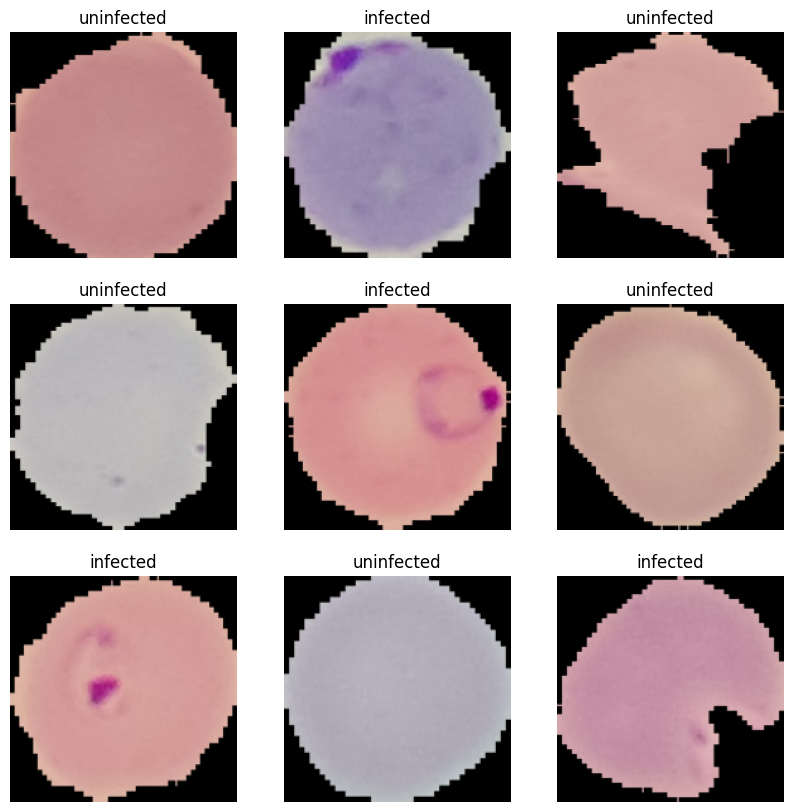

In [ ]:
# Visualise the Training Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

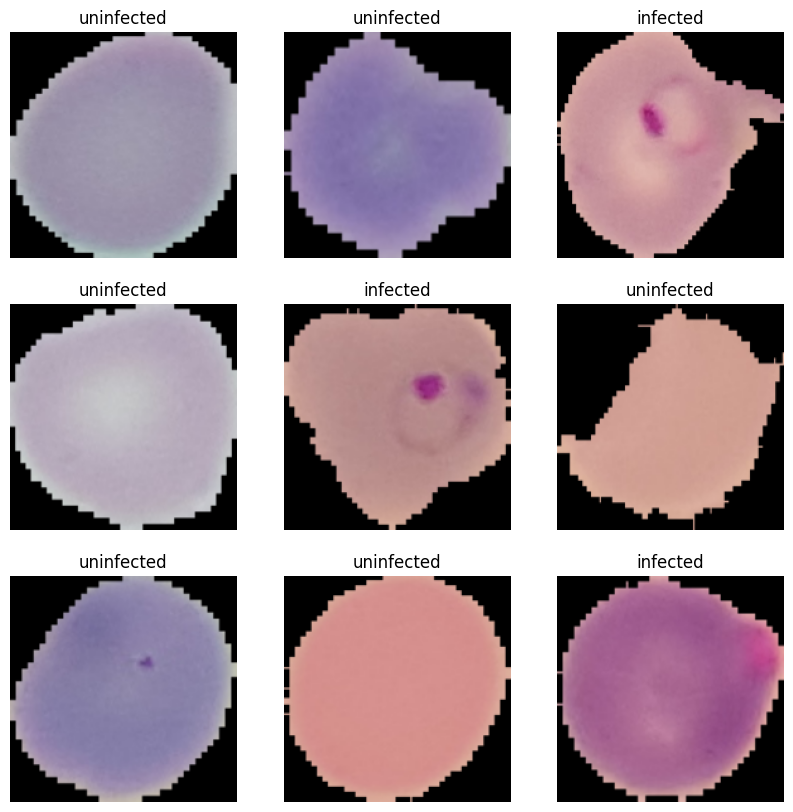

In [ ]:
# Visualise the Validation Dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Standardise the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds  = val_ds .cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augementation
data_augmentation = tf.keras.Sequential([
  normalization_layer,
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  layers.RandomContrast(0.2),
  layers.RandomBrightness(0.2)
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
num_classes = len(class_names)

# Train Model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and compile the model
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 90, 90, 64)       

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_ds,
    batch_size=32,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
693/693 [==============================] - 614s 715ms/step - loss: 3.1539 - accuracy: 0.4957 - val_loss: 12.3621 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 2/25
693/693 [==============================] - 481s 694ms/step - loss: 1.4806 - accuracy: 0.5020 - val_loss: 7.2910 - val_accuracy: 0.5054 - lr: 1.0000e-04
Epoch 3/25
693/693 [==============================] - 475s 685ms/step - loss: 1.0484 - accuracy: 0.5043 - val_loss: 1.0748 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 4/25
693/693 [==============================] - 474s 683ms/step - loss: 0.8902 - accuracy: 0.4951 - val_loss: 0.8239 - val_accuracy: 0.5018 - lr: 1.0000e-04
Epoch 5/25
693/693 [==============================] - 472s 681ms/step - loss: 0.8231 - accuracy: 0.4965 - val_loss: 0.7705 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 6/25
693/693 [==============================] - 471s 679ms/step - loss: 0.7850 - accuracy: 0.4999 - val_loss: 0.7524 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 7/25
693/693 [=

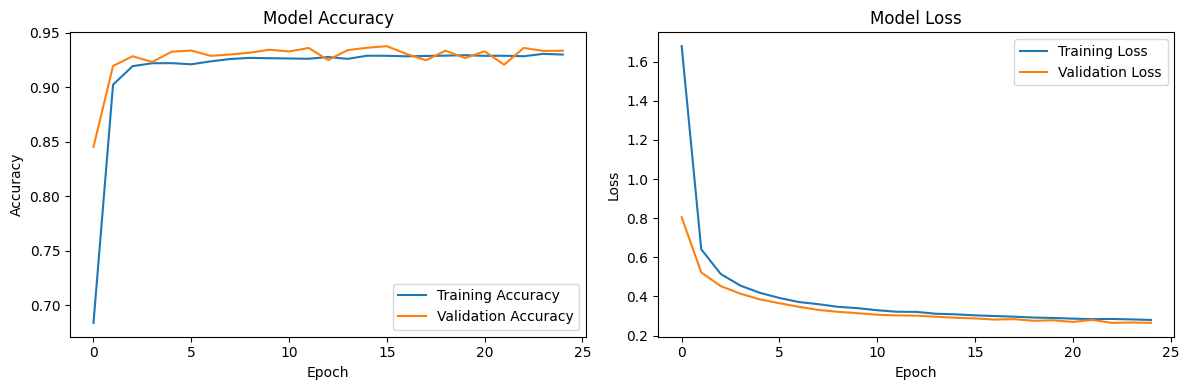

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function to predict and display results
def predict_and_display(model, img_path, target_size=(img_height, img_height)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        X = image.img_to_array(img)
        X = X / 255.0  # Normalize the image
        X = np.expand_dims(X, axis=0)

        val = model.predict(X)

        prediction = "uninfected" if val[0][0] > 0.5 else "infected"
        print(f"Predicted: {prediction}")

        return val[0][0]
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")
        return None

# Get list of all images and randomly select 100
all_images = os.listdir(test_path)
selected_images = random.sample(all_images, min(100, len(all_images)))

# Process selected images
results = []
true_labels = []
for i in selected_images:
    img_path = os.path.join(test_path, i)
    print(f"\nProcessing image: {i}")
    probability = predict_and_display(model, img_path)
    if probability is not None:
        results.append({'image': i, 'probability': probability})
        # Assuming the true label is in the filename (e.g., "infected_001.png")
        true_label = 1 if "uninfected" in i.lower() else 0
        true_labels.append(true_label)

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Image: {result['image']}, Probability of being uninfected: {result['probability']:.4f}")

# Calculate overall statistics
predicted_labels = [1 if r['probability'] > 0.5 else 0 for r in results]

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nTotal images processed: {len(results)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()